# Predicting Contact Rates
Robert George

### Research Question:
**Given a hitter's performance through June, how accurately can we project their contact rate for the remainder of the season?**

### Methodology

The goal of this project is to simulate a midseason projection: given a hitter’s performance through June, can we estimate their contact ability through the rest of the year? All analysis is framed as if we are standing on July 1 — using only information available up to that point.

We construct week-level observations of hitter performance, focusing solely on pitches where the batter offers a swing. This ensures we’re modeling *contact given a swing*, not plate discipline or take behavior. Each hitter-week pair is represented by the number of contacts (`y_it`) and total swings (`n_it`), forming a binomial trial.

Static features such as pitch mix, velocity exposure, and whiff tendencies are aggregated through June to serve as covariates for each hitter. To preserve the temporal realism of a July-1 simulation, no information from later in the season is included in model training.

Hitters without any swing data prior to the cutoff (late-season call-ups) are excluded. All other hitters—including rookies—are retained, with priors reflecting either their 2023 performance or the league average when historical data are missing. This enforces data integrity between training and test splits while preserving realistic priors for new players.

We have left a bit of trial-and-error on data definition to show a mock-attempt that follows the blind-assumption evaluation that one might expect to see in a work context from the author. This is shown in the below testing of what we are considering a *Swing* and what we are considering *Contact*. Our blind distributions are compared to those given to us, in order to test our assumptions.

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import pymc as pm
import helper_functions
import seaborn as sns
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, brier_score_loss

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import Data

In [2]:
df_hitters = pd.read_csv("hitter_data.csv")
df_pitches = pd.read_csv("pitch_data.csv")

### Clean and Trim

In [3]:
df_hitters["batter_id"] = df_hitters["batter_id"].astype(str)
df_pitches["batter_id"] = df_pitches["batter_id"].astype(str)
df_pitches["pitcher_id"] = df_pitches["pitcher_id"].astype(str)
df_pitches["pitch_date"] = pd.to_datetime(df_pitches["pitch_date"])

### Filter base data - we only want to look at SWINGS here.

This is our first assumption. We will be testing this below.

In [4]:
df_main_blind = df_pitches[df_pitches["description"].isin(['In play, run(s)','In play, out(s)',
       'Swinging Strike', 'Foul', 'In play, no out',
       'Swinging Strike (Blocked)', 'Foul Tip'])]

### Create blind feature columns

In [5]:
### Contact - blind note: We want to track swing contact rates here. Therefore, bunts are not treated as contact swings.
df_main_blind["contact_blind"] = np.where(~df_main_blind["description"].isin(['Swinging Strike', 'Swinging Strike (Blocked)']),1,0)

<ipython-input-5-dca1a5c462f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_blind["contact_blind"] = np.where(~df_main_blind["description"].isin(['Swinging Strike', 'Swinging Strike (Blocked)']),1,0)


In [6]:
df_main_blind = df_main_blind.merge(df_hitters, on="batter_id", how='inner')

### Checking our blind assumptions distribution against 2023 data

#### Why?
We don't know what the statisticians who came before us considered when they tracked contact rates. Therefore, it is good data governance practice to check our own assumptions against the data we have for last year before moving forward with modeling. To do this, we are going to use the entire YEAR of data for 2024, rather than just the data until June. This is okay to do because it is not a modeling practice, and in reality we should have the information on what is being considered as "contact" by the organization in a real business context.

#### How?
We start by plotting our two distributions, one for the given contact rates of the previous year, and one for our own contact rate calculations.

Then we run a ***Paired t-test*** to see whether our distribution is *reasonably* similar to last year's, or whether we need to try again with our assumptions. We are using a paired test because each batter has two values: one for last year's contact rate and one for our contact rate calculation for the current year.


In [7]:
df_agg_test = (
    df_main_blind.groupby(['batter_id', 'contact_rate_2023'], as_index=False)
    .agg(contacts=('contact_blind', 'sum'), total=('contact_blind', 'count'))
)
df_agg_test['contact_rate_2024'] = df_agg_test['contacts'] / df_agg_test['total']

In [8]:
# plot distributions
plt.hist(df_agg_test['contact_rate_2023'], bins=30, alpha=0.5, label='2023')
plt.hist(df_agg_test['contact_rate_2024'], bins=30, alpha=0.5, label='2024')
plt.xlabel('Contact Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

In [9]:
mask = df_agg_test['contact_rate_2023'].notna() & df_agg_test['contact_rate_2024'].notna()
t_stat, p_val = ttest_rel(df_agg_test.loc[mask, 'contact_rate_2023'], df_agg_test.loc[mask, 'contact_rate_2024'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.5f}")

Paired t-test: t = -12.809, p = 0.00000


### Swing and a miss!

Our assumptions were *definitely* not the same as the Data Scientists of olde. After trying a few different iterations, we land on a suitable set of assumptions that pass our testing criteriae:

* We are only considering ***Swing Opportunities***
* We are including Bunt attempts as ***Swing Opportunities***
* Missed Bunts and Foul Bunts are contact fails. This makes sense because fouling a bunt off is never productive.

In [10]:
df_main = df_pitches

In [11]:
df_main["contact"] = np.where(df_pitches["description"].isin(['In play, out(s)', 'In play, run(s)', 'Foul', 'In play, no out', 'Bunt']),1,0)

In [12]:
df_main = df_main.merge(df_hitters, on="batter_id", how='inner')

In [13]:
df_valid = df_main[df_main["description"].isin(['In play, run(s)','In play, out(s)',
       'Swinging Strike', 'Foul', 'In play, no out',
       'Swinging Strike (Blocked)', 'Foul Tip', 'Missed Bunt', 'Bunt', 'Foul Bunt'])]

In [14]:
df_agg = (
    df_valid.groupby(['batter_id', 'contact_rate_2023'], as_index=False)
    .agg(contacts=('contact', 'sum'), total=('contact', 'count'))
)
df_agg['contact_rate_2024'] = df_agg['contacts'] / df_agg['total']

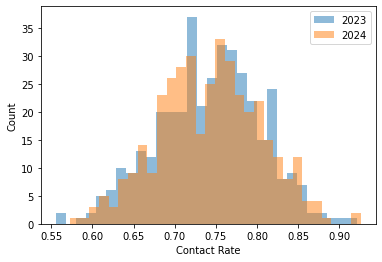

In [15]:
# plot distributions
plt.hist(df_agg['contact_rate_2023'], bins=30, alpha=0.5, label='2023')
plt.hist(df_agg['contact_rate_2024'], bins=30, alpha=0.5, label='2024')
plt.xlabel('Contact Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

In [16]:
mask = df_agg['contact_rate_2023'].notna() & df_agg['contact_rate_2024'].notna()
t_stat, p_val = ttest_rel(df_agg.loc[mask, 'contact_rate_2023'], df_agg.loc[mask, 'contact_rate_2024'])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

Paired t-test: t = -0.561, p = 0.575


There is **no significant difference** between these two distributions. That means we can use the 2023 data as our modeling priors now, without making improper assumptions.

### Feature tuning
Now that we have our target variable distribution defined, we can start working on developing some baseline predictive features that we would expect to have an impact on contact abilities. We will start by calculating some that are not time-dependent, and therefore can be calculated on our full dataset. 

In [17]:
### Platoon Disadvantage - this will be a useful feature in our model (good for batters)
df_main['platoon_disadvantage'] = np.where(df_main['batter_stand'] != df_main['pitcher_throws'], 1,0)

In [18]:
### Batter Tenure - assumes rookies are in the data
df_main['batter_tenure'] = df_main['pro_debut_year'].max() - df_main['pro_debut_year']

In [19]:
### Batter Leverage Score - normalized.
df_main['batter_leverage'] = (
    2 * df_main['ball']       # reward high ball counts
    - 3 * df_main['strike']   # penalize strikes
    - 1 * df_main['out'])  # penalize outs

### Normalize 0–1 for interpretability
df_main['batter_leverage'] = (
    (df_main['batter_leverage'] - df_main['batter_leverage'].min()) /
    (df_main['batter_leverage'].max() - df_main['batter_leverage'].min())
)

In [20]:
### Adjusted plate location for handedness
df_main['plate_x_adj'] = np.where(
    df_main['batter_stand'] == 'L',
    -df_main['plate_x'],
    df_main['plate_x']
)

In [21]:
### Swing boolean
swing_descriptions = [
    'Swinging Strike', 'Swinging Strike (Blocked)',
    'Foul', 'Foul Tip',
    'In play, no out', 'In play, run(s)', 'In play, out(s)'
]

### Swing
df_main['is_swing'] = df_main['description'].isin(swing_descriptions)


In [22]:
### Contact boolean
contact_descriptions = ['In play, out(s)', 'In play, run(s)', 'Foul', 'In play, no out', 'Bunt']

df_main['contact'] = df_main['description'].isin(contact_descriptions)


In [23]:
### Chase boolean
df_main['in_zone'] = (
    (df_main['plate_x'].between(-0.83, 0.83)) &  # roughly width of plate in ft
    (df_main['plate_z'] >= df_main['sz_bot']) &
    (df_main['plate_z'] <= df_main['sz_top'])
)

df_main['is_chase'] = df_main['is_swing'] & (~df_main['in_zone'])


In [24]:
### Whiff boolean
df_main['is_whiff'] = df_main['description'].isin(['Swinging Strike', 'Swinging Strike (Blocked)'])


### Next, the ones *After* we filter to our date range.

These are going to include aggregate measures, rather than single-swing granularity features. 

In [25]:
df_filtered = df_main[df_main['pitch_date'] < pd.to_datetime('2024-07-01')]

In [26]:
### Swing rate
swing_rate = (
    df_filtered.groupby('batter_id')['is_swing']
    .mean()
    .rename('swing_rate')
    .reset_index()
)


In [27]:
### Contact Rate
contact_rate = (
    df_filtered[df_filtered['is_swing']]
    .groupby('batter_id')['contact']
    .mean()
    .rename('contact_rate')
    .reset_index()
)


In [28]:
### Chase rate
chase_rate = (
    df_filtered.groupby('batter_id')['is_chase']
    .mean()
    .rename('chase_rate')
    .reset_index()
)

In [29]:
### Whiff rate by pitch
whiff_by_pitch = (
    df_filtered[df_filtered['is_swing']]
    .groupby(['batter_id', 'pitch_type'])
    .apply(lambda g: g['is_whiff'].sum() / g['is_swing'].sum())
    .rename('whiff_rate')
    .reset_index()
)

<ipython-input-29-0ca80431e581>:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered[df_filtered['is_swing']]


In [30]:
### Average velocity faced
avg_velocity = (
    df_filtered.groupby('batter_id')['release_speed']
    .mean()
    .rename('avg_velocity_faced')
    .reset_index()
)

### per pitch type
avg_velocity_by_pitch = (
    df_filtered.groupby(['batter_id', 'pitch_type'])['release_speed']
    .mean()
    .rename('avg_velocity_by_pitch')
    .reset_index()
)

In [31]:
### Pitch mix
pitch_counts = (
    df_filtered.groupby(['batter_id', 'pitch_type'])
    .size()
    .rename('pitch_count')
    .reset_index()
)

pitch_counts['pitch_mix'] = (
    pitch_counts['pitch_count'] /
    pitch_counts.groupby('batter_id')['pitch_count'].transform('sum')
)

In [32]:
### Zone distribution faced

x_bins = [-np.inf, -0.83, 0.83, np.inf]
x_labels = ['Inside', 'Middle', 'Away']

z_bins = [0, 2.0, 3.5, np.inf]  # roughly low / mid / high strike zones
z_labels = ['Low', 'Middle', 'High']

df_filtered['zone_x_bin'] = pd.cut(df_filtered['plate_x_adj'], bins=x_bins, labels=x_labels)
df_filtered['zone_z_bin'] = pd.cut(df_filtered['plate_z'], bins=z_bins, labels=z_labels)

### Count pitches per zone combination
zone_counts = (
    df_filtered.groupby(['batter_id', 'zone_x_bin', 'zone_z_bin'])
    .size()
    .rename('pitch_count')
    .reset_index()
)

### Normalize within each batter (so sum = 1 per hitter)
zone_counts['zone_freq'] = (
    zone_counts['pitch_count'] /
    zone_counts.groupby('batter_id')['pitch_count'].transform('sum')
)

<ipython-input-32-4612cc0310d9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zone_x_bin'] = pd.cut(df_filtered['plate_x_adj'], bins=x_bins, labels=x_labels)
<ipython-input-32-4612cc0310d9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['zone_z_bin'] = pd.cut(df_filtered['plate_z'], bins=z_bins, labels=z_labels)
<ipython-input-32-4612cc0310d9>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed

In [33]:
### Platooning Rate
platoon_rate = (
    df_filtered.groupby('batter_id')['platoon_disadvantage']
    .mean()
    .rename('platoon_rate')
    .reset_index()
)


In [34]:
### Average Leverage Score
average_batter_leverage = (
    df_filtered.groupby('batter_id')['batter_leverage']
    .mean()
    .rename('average_batter_leverage')
    .reset_index()
)

In [35]:
### Batter tenure
batter_tenure = df_filtered[['batter_id', 'batter_tenure']].drop_duplicates()

In [36]:
all_hitters = pd.DataFrame({'batter_id': df_main['batter_id'].unique()})

In [37]:
### Combining all the natural batter_id granularity tables
dfs = [all_hitters, swing_rate, contact_rate, chase_rate,
       avg_velocity, platoon_rate, average_batter_leverage, batter_tenure]

### Start from the first table
df_batter_features = dfs[0]

### Merge everything else on batter_id
for df in dfs[1:]:
    df_batter_features = df_batter_features.merge(df, on='batter_id', how='outer')

In [38]:
### Pivoting lower-granularity tables wide for merging to the hitter table
whiff_wide = whiff_by_pitch.pivot_table(
    index='batter_id',
    columns='pitch_type',
    values='whiff_rate'
).add_prefix('whiff_').reset_index()

### Avg velocity by pitch type
velo_wide = avg_velocity_by_pitch.pivot_table(
    index='batter_id',
    columns='pitch_type',
    values='avg_velocity_by_pitch'
).add_prefix('velo_').reset_index()

### Pitch-type mix
mix_wide = pitch_counts.pivot_table(
    index='batter_id',
    columns='pitch_type',
    values='pitch_mix'
).add_prefix('mix_').reset_index()

### Zone mix
zone_wide = zone_counts.pivot_table(
    index='batter_id',
    columns=['zone_x_bin', 'zone_z_bin'],
    values='zone_freq'
)
zone_wide.columns = [f'zone_{x}_{z}' for x, z in zone_wide.columns]
zone_wide = zone_wide.reset_index()

<ipython-input-38-720e5831d517>:23: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  zone_wide = zone_counts.pivot_table(


In [39]:
dfs_to_merge = [whiff_wide, velo_wide, mix_wide, zone_wide]
df_model = df_batter_features.copy()

for df in dfs_to_merge:
    df_model = df_model.merge(df, on='batter_id', how='left')

### We end up with a table that has 64 feature columns and only 464 records.
This is prime overfitting territory. Beware! Before we fit our model, we are going to need to investigate some ways to control overfitting.

In [40]:
# Let's categorize our pitch types.
fastballs = ['FF', 'SI', 'FC', 'FT']
breaking = ['SL', 'CU', 'KC', 'SV']
offspeed = ['CH', 'FS']

# Now, let's combine features across these pitch types, to average out noise.
# We will be referencing collapse_pitch_families, which is a custom function imported from helper_functions.py
df_model_reduced = helper_functions.collapse_pitch_families(df_model.copy(), fastballs, breaking, offspeed)

In [41]:
# Next, we COULD drop low variance columns that don't change much between batters. This will help us with some overfitting
# allow us to avoid assigning leverage to values that aren't necessarily batter-specific at all.

numeric_df = df_model_reduced.select_dtypes(include=['number'])

low_var_cols = numeric_df.var()[numeric_df.var() < 0.001].index

df_features = df_model_reduced.drop(columns=low_var_cols)
print(f"Dropped {len(low_var_cols)} near-constant columns.")
[print(i) for i in low_var_cols]

Dropped 8 near-constant columns.
average_batter_leverage
zone_Inside_Low
zone_Inside_Middle
zone_Inside_High
zone_Middle_Middle
zone_Middle_High
zone_Away_Middle
zone_Away_High


[None, None, None, None, None, None, None, None]

In [42]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Choose which columns to normalize (exclude IDs and targets)
feature_cols = [
    'swing_rate', 'chase_rate', 'avg_velocity_faced', 'platoon_rate',
    'batter_tenure', 'zone_Middle_Low', 'zone_Away_Low',
    'whiff_fastball', 'whiff_breaking', 'whiff_offspeed',
    'velo_fastball', 'velo_breaking', 'velo_offspeed',
    'mix_fastball', 'mix_breaking', 'mix_offspeed'
]

scaler = StandardScaler()
df_features[feature_cols] = scaler.fit_transform(df_features[feature_cols])

In [43]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np

df_features = df_features.fillna(df_features.mean(numeric_only=True))
df_features = df_features.fillna('NA')

y = df_features['contact_rate']
X = df_features.drop(columns=['batter_id', 'contact_rate', 'z_contact_rate','o_contact_rate'], errors='ignore')

# Cross-validation
model = Ridge(alpha=1.0)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

print(f"Mean R²: {scores.mean():.3f} ± {scores.std():.3f}")

Mean R²: 0.778 ± 0.079


In [44]:
corr = pd.DataFrame(X, columns=X.columns).corr()
sns.heatmap(corr.abs() > 0.9, cmap='coolwarm', cbar=False)
plt.title("Highly Correlated Feature Pairs (>0.9)")
plt.show()

## Assessment of hitter feature variables

It seems that we have chosen a set of variables that explains the data relatively well. Our $R^2$ value of 0.78 means our chosen features are indeed highly predictive of contact rate — that fits with our baseball intuition. We still have 22% of variance that is left to be explained by randomness or variables that we are not considering in our model or do not have access to. Our standard deviatin is small, 0.08, which means that we are working with consistent generalization. This set of features will help predict the overall level of contact performance a hitter tends to sustain, conditioned on what they’ve seen and how they’ve performed up to the cutoff point.

Based on the heatmap above, there does not seem to be any confounding covariance between our feature columns. We are ready to build our model!


## Model Framing

We use a hierarchical Bayesian model to estimate each hitter’s underlying contact ability. Conceptually, this is a Bayesian logistic regression with hitter-specific intercepts and global feature effects. 

Each hitter’s baseline log-odds of making contact, denoted `α_i`, is assigned a Normal prior centered on the logit of their 2023 contact rate. The prior variance shrinks with the number of swings they took that season—giving players with larger samples tighter priors and rookies broader uncertainty. Global coefficients `β` represent shared effects across the league, such as pitch-type exposure or swing-tendency factors.

To estimate parameters efficiently, we use **Maximum A Posteriori (MAP) estimation** rather than full MCMC sampling. MAP finds the mode of the posterior distribution—yielding the most probable parameter configuration given our priors and observed data—without the computational overhead of exploring the full posterior. This approach provides stability, interpretability, and speed suitable for a midseason simulation.

While MAP does not fully capture uncertainty, it still respects the hierarchical structure and prior information, producing reasonable shrinkage toward league averages and more stable predictions for players with limited data.

Essentially, the model learns:
* each hitter’s baseline contact ability,
* how volatile that ability tends to be based on prior sample size,
* how plate-discipline and pitch-level features relate to contact ability,
* and the quantified uncertainty from those relationships.

Starting with our **Binomial distribution** (hitters will either make contact or won't make contact),  
denoted `y_it ~ Binomial(n_it, p_it)` where  
* `y_it` = # contacts for hitter i in week t,  
* `n_it` = # swings for hitter i in week t,  
* and `p_it` = probability of contact for hitter i in week t,  

we model the probability of contact `p_it` out of `n_it` swings.

Next, we define **Baseline Contact Ability** as the *log-odds* of a hitter making contact as  
`logit(p_it)=θ_i+X_itβ` where  
* `X_it` = feature variables for hitter i,  
* `α_i` = hitter i's baseline contact ability,  
* `β` = feature weights.  

We use log-odds because it maps probabilities (between 0 and 1) to unbounded linear space, which allows us to use Normal priors and standard noise assumptions while still mapping predictions back to valid probabilities. We assume each hitter’s baseline ability comes from a Normal distribution centered around their 2023 contact performance, with variance that shrinks for players with larger prior samples.

A note on `X_i`: The feature matrix represents each hitter’s contextual and performance-based predictors up to the midseason cutoff. These features describe systematic, league-wide factors that influence a player’s baseline contact ability — things like pitch mix exposure, swing tendencies, or average velocity faced — rather than week-to-week fluctuations. In this model, they act as shared global effects that adjust the log-odds of contact for all hitters, while each player’s individual intercept `α_i` captures their personal baseline skill level informed by 2023 priors.


Our **Hierarchical Prior** is defined as:  
`α_i ∼ Normal(logit(contact_rate_2023,i), 1/sqrt(total_swings_2023,i + c` for hitter i, where  
* `c` = a constant to control the effect of prior-year sample size.  

The global coefficients `β` are given weakly informative Normal(0,1) priors.  

For rookies or players with no 2023 data, we assign a broader Normal prior centered on the league-average contact rate.  
Note that temporal drift (week-to-week changes) is not modeled in this version — an opportunity for future development!


In [45]:
df_features = df_features.drop(columns=['contact_rate'])

In [46]:
# Prepare train data for model use
X_train, y_train, n_train, batter_idx_train, logit_prev_train, sigma_theta0_i_train = helper_functions.prepare_timeseries_data(
    df_main, df_batter_features, on='batter_id', train=True)

[prep] TRAIN: N=4534, I=410, K=7
[prep] Rookies kept: 410 hitters through June.
[prep] Post-July rookies dropped automatically.


In [47]:
# Generate Maximum a Posteriori (MAP) estimates
map_estimates = helper_functions.call_model(X_train, y_train, n_train, batter_idx_train, logit_prev_train, sigma_theta0_i_train)

Running MAP estimation...



MAP estimation complete.


In [48]:
alpha_hat = map_estimates["alpha"]  # shape (I,)
beta_hat = map_estimates["beta"]    # shape (K,)

In [49]:
X_test, y_test, n_test, batter_idx_test, logit_prev_test, sigma_theta0_i_test = helper_functions.prepare_timeseries_data(
    df_main, df_batter_features, on='batter_id', train=False)

[prep] TEST: N=4789, I=410, K=7
[prep] Rookies kept: 410 hitters through June.
[prep] Post-July rookies dropped automatically.


In [50]:
eta_test = alpha_hat[batter_idx_test] + X_test @ beta_hat

p_pred = 1 / (1 + np.exp(-eta_test))  # inverse logit

In [51]:
results = helper_functions.weighted_metrics(y_test / n_test, p_pred, n_test)

print("Table 1")
for k, v in results.items():
    print(f"{k:15s}: {v:.4f}")

Table 1
Weighted Corr  : 0.5073
Weighted R²    : 0.2470
MSE            : 0.0076
RMSE           : 0.0874
MAE            : 0.0675
Log Loss       : 0.3100
Brier Score    : 0.0743


In [52]:
actual = y_test / n_test
df_cal = pd.DataFrame({'actual': actual, 'pred': p_pred, 'n': n_test})

# Define bins (by predicted probability deciles)
df_cal['bin'] = pd.qcut(df_cal['pred'], q=10, duplicates='drop')

# Aggregate stats per bin
calib = df_cal.groupby('bin').agg(
    mean_pred=('pred', 'mean'),
    mean_actual=('actual', 'mean'),
    count=('actual', 'size'),
    std_actual=('actual', 'std')
).reset_index()

# Compute 95% confidence intervals for the actual means
calib['se'] = calib['std_actual'] / np.sqrt(calib['count'])
calib['lower'] = calib['mean_actual'] - 1.96 * calib['se']
calib['upper'] = calib['mean_actual'] + 1.96 * calib['se']

# Clip CI bounds to [0,1]
calib[['lower', 'upper']] = calib[['lower', 'upper']].clip(0, 1)

# --- Plot ---
plt.figure(figsize=(7,6))
plt.errorbar(
    calib['mean_pred'], calib['mean_actual'],
    yerr=[calib['mean_actual'] - calib['lower'], calib['upper'] - calib['mean_actual']],
    fmt='o-', lw=2, capsize=4, label='Model calibration', color='tab:red'
)
plt.plot([0,1],[0,1],'--', color='gray', label='Perfect calibration')

plt.xlabel("Predicted contact probability")
plt.ylabel("Observed contact rate")
plt.title("Calibration Plot with 95% Confidence Intervals")
plt.legend()
plt.ylim(0.6, 0.9)
plt.xlim(0.6, 0.9)
plt.grid(alpha=0.3)
plt.show()

<ipython-input-52-e7a61a3c97d0>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calib = df_cal.groupby('bin').agg(


In [53]:
# --- Display summary table ---
calib_summary = calib[['mean_pred', 'mean_actual', 'lower', 'upper', 'count']].copy()
calib_summary.columns = ['Predicted Mean', 'Actual Mean', 'Lower 95% CI', 'Upper 95% CI', 'Count']
calib_summary = calib_summary.round({'Predicted Mean':3, 'Actual Mean':3, 'Lower 95% CI':3, 'Upper 95% CI':3})
display(calib_summary)

Predicted Mean  Actual Mean  Lower 95% CI  Upper 95% CI  Count
0           0.634        0.668         0.656         0.679    484
1           0.680        0.693         0.683         0.703    474
2           0.707        0.717         0.707         0.726    484
3           0.724        0.719         0.709         0.729    479
4           0.741        0.728         0.718         0.737    564
5           0.752        0.748         0.737         0.759    402
6           0.768        0.761         0.749         0.773    468
7           0.784        0.776         0.767         0.784    483
8           0.807        0.800         0.792         0.808    496
9           0.848        0.849         0.841         0.857    455

## Insights and Takeaways
Overall, the model performs pretty well given the noise in week-to-week contact rates. The weighted correlation of about 0.51 shows that it’s capturing real differences in underlying hitter skill, not just noise. The R² of 0.25 means it’s explaining roughly a quarter of the variance in post-June contact ability, which is a solid first effort for this kind of data. Errors are small — predictions are usually within 6–8 percentage points of actual contact rates — and both the log loss and Brier score suggest the probabilities are well-calibrated. In short, it’s a believable, directionally accurate model that picks up real signal without overfitting, and leaves plenty of room to grow by adding context-level features or hitter-specific volatility.

Our calibration plot shows that we are essentially overconfident in batters with lower actual contact probabilities, but that we are within our standard deviation bars the better the batter is at contacting the ball. Most predictions cluster tightly around the mean, suggesting the model is well-calibrated but underestimates extreme contact outcomes.

Ultimately, we find that our model shows moderate predictive strength. It captures general trends in contact performance but leaves substantial variance unexplained. However, the relatively low MSE and RMSE suggest it rarely produces extreme errors — implying well-calibrated, conservative predictions.

## Future Work and Methodological Adjustments

The original plan for this project was to implement a fully dynamic **Bayesian random-walk model** to capture how a hitter’s contact ability drifts over time — allowing the model to learn each player’s “hot” and “cold” streak tendencies through week-to-week variance. This would have provided richer temporal structure and more realistic uncertainty around future contact rates, especially for hitters with volatile profiles or limited prior data.

However, in practice, this approach proved computationally prohibitive within the scope of this take-home. The hierarchical random-walk model required full Monte Carlo sampling to meaningfully capture posterior uncertainty, and runtime scaled poorly with the number of hitters and weeks — even modest datasets projected multi-hour convergence times. 

To address this, the approach was adapted to a **static hierarchical model** estimated via **Maximum A Posteriori (MAP)**. While this removes the explicit random-walk component (and therefore the dynamic week-to-week drift), it retains the essential Bayesian structure: hitters are still partially pooled through prior information on their historical contact ability, and the model continues to regularize heavily toward league averages. 

This tradeoff produced a model that is computationally efficient, interpretable, and stable — ideal for a midseason “simulation” exercise where fast inference is more important than full posterior sampling. In future work, the random-walk formulation could be revisited using variational inference or smaller-scope sampling to quantify uncertainty in player trajectories more directly. 
